In [1]:
import tensorly as tl
import numpy as np

Using numpy backend.


One of the most great features of tensors is that they can be represented compactly in decomposed form and we have powerful methods with guarantees to obtain these decomposition.

# Kruskal form of a tensor

Just as a matrix can be expressed as the sum of outer product of two vectors, a tensor of order 3 can be expressed as the sum of outer products of three vectors, and a tensor of order $N$ can be expressed as a sum of outer product of $N$ vectors. The number of terms in the sum is then called the Kruskal rank of the tensor.


## Obtain a Kruskal form: CP decomposition
Given a tensor, an given a rank $R$, you can get the rank-$R$ Kruskal form  of the tensor by applying Canonical Polyadic Decomposition (also known as CP or PARAFAC).

In TensorLy, it is as simple as a function call:

In [2]:
from tensorly.decomposition import parafac
X = tl.tensor(np.arange(24).reshape((3, 4, 2)))

In [3]:
factors = parafac(X, rank=2)

The parafac function decomposed our tensor X into a sum (here, with 2 terms) of rank 1 tensors, that is, the outer product of vectors (here 3 vectors since we are decomposing a tensor of order 3):

There is one matrix (or factor) per mode of the tensor. Each column of these factors corresponds to one of the vectors of the decomposition.

In [4]:
len(factors)

3

In [5]:
[f.shape for f in factors]

[(3, 2), (4, 2), (2, 2)]

Here, we have two terms in the sum, so we have two vectors for each mode.

You can also reform the whole tensor from the Kruskal form:

In [6]:
full_tensor = tl.kruskal_to_tensor(factors)
full_tensor.shape

(3, 4, 2)

# Tucker form of a tensor

The Tucker form can be seen as a generalisation of the Kruskal form. A tensor is then express as a core and a set of projection matrices for each mode. A Kruskal tensor is then a Tucker tensor with a super-diagonal core.

The size of the core is also a called n-Rank

## Obtaining the Tucker form: Tucker decomposition

The Tucker form is obtained by applying Tucker decomposition to the original tensor, which, again, is easy to do in TensorLy:

In [7]:
from tensorly.decomposition import tucker

Let's define a simple tensor to decompose:

In [8]:
X = tl.tensor(np.arange(24).reshape((3, 4, 2)))

In [9]:
core, factors = tucker(X, ranks=[3, 4, 2])

In [10]:
core.shape

(3, 4, 2)

Reforming the full tensor

In [11]:
full_tensor = tl.tucker_to_tensor(core, factors)
full_tensor.shape

(3, 4, 2)

# Application: image compression

Let's load an image and compress it with Tucker:

In [32]:
from scipy.misc import face
import matplotlib.pyplot as plt
%matplotlib inline 

# Load the face
image1 = face()

# Let's load an astronaut image from scikit-image
#     and excellent Python library for image manipulation
# (if you don't have it you can pip install scikit-image)
from skimage.data import astronaut

image2 = astronaut()

# Convert it to a tensor of floats
image = np.array(image, dtype=np.float64)
image2 = np.array(image2, dtype=np.float64)


def to_image(tensor):
    """convert a tensor of float values into an image
    """
    tensor -= tensor.min()
    tensor /= tensor.max()
    tensor *= 255
    return tensor.astype(np.uint8)

Our image is a thrid order tensor (height x width x channels) where channels are Red, Blue and Green (RGB):

In [33]:
image1.shape

(768, 1024, 3)

However, both images don't have the same size:

In [34]:
image2.shape

(512, 512, 3)

Let's resize image1 so they are both 512x512x3

In [35]:
from scipy.misc import imresize

In [36]:
image1 = np.array(imresize(face(), [512, 512, 3]), dtype=np.float64)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


Let's visualise the images:

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


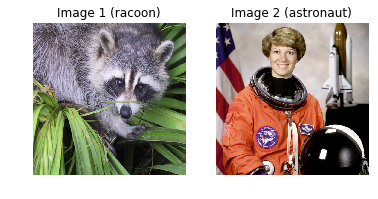

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(to_image(image1))
ax.set_axis_off()
plt.title('Image 1 (racoon)')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(to_image(image2))
ax.set_axis_off()
plt.title('Image 2 (astronaut)')
fig.show()

## Experimenting with Tucker

Now we can compress our image with a Tucker decomposition (as rank, we divide by 10 the height and width, while keeping a rank of 3 for the color channels):

In [57]:
core, factors = tucker(image1, rank=[50, 50, 3])

We can reconstruct the image from the decomposed form:

In [58]:
rec_image = tl.tucker_to_tensor(core, factors)

Let's visualise it:

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


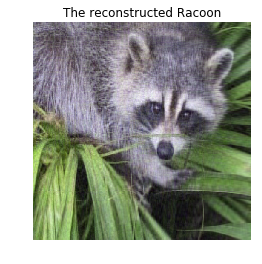

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(to_image(rec_image))
ax.set_axis_off()
plt.title('The reconstructed Racoon')
fig.show()

What do you think happens if we decrease the rank along the channels to 1?

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


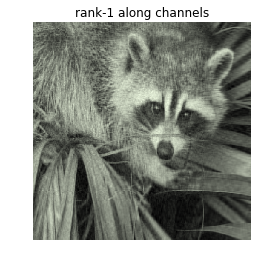

In [61]:
core, factors = tucker(image1, rank=[50, 50, 1])
rec_image = tl.tucker_to_tensor(core, factors)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(to_image(rec_image))
ax.set_axis_off()
plt.title('rank-1 along channels')
fig.show()

Does this match what you expected? Since we only have a rank one along the color channels, we cannot model all color variations.

SO then, what do you expect would happen with 2 channels?

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


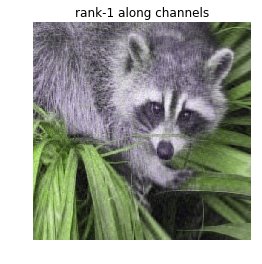

In [62]:
core, factors = tucker(image1, rank=[50, 50, 2])
rec_image = tl.tucker_to_tensor(core, factors)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(to_image(rec_image))
ax.set_axis_off()
plt.title('rank-1 along channels')
fig.show()

As you see it's not perfect but the quality is decent. Here, there is very little red so we only need 2 channels to have a decent result.

The interesting thing is that now our image is represented as a compact $40 \times 40 \times 3$ core, while we have factor matrices to project to and from that image!

Let's try to compress our astronaut image using the factors learned on our Racoon. Intuitively, what do you expect?

In [63]:
# We project our second image to the same subspace learned on the racoon image
# The factor are orthonormal so the transpose is the inverse:
core = tl.tenalg.multi_mode_dot(image2, factors, transpose=True)

And again, we can reconstruct our image:

In [64]:
new_rec = tl.tucker_to_tensor(core, factors)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


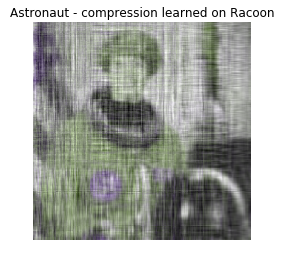

In [65]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(to_image(new_rec))
ax.set_axis_off()
plt.title('Astronaut - compression learned on Racoon')
fig.show()

Not great, and you can see that, because we only used a rank 2 along the channels, and the racoon doesn't have red, we don't have red here either!

Now, a better thing would be to concatenate the two images and learn a joint subspace, so let's do this!

In [66]:
from tensorly.decomposition import partial_tucker

In [67]:
tensor = tl.concatenate([image1[None, ...], image2[None, ...]], axis=0)

In [68]:
tensor.shape

(2, 512, 512, 3)

We now have a tensor that contains both images (you could add as many as you want).
You can now learn a partial tucker, i.e. learn projection only for the last free modes (we don't want to reduce the rank along the samples axis).

Fortunately, you can do this easily with TensorLy:

In [69]:
core, factors = partial_tucker(tensor, ranks=[50, 50, 3], modes=[1, 2, 3])

In [70]:
[f.shape for f in factors]

[(512, 50), (512, 50), (3, 3)]

Let's once again inspect our reconstruction (we use the same factors for both images, as they have been learned jointly)

In [71]:
core1 = tl.tenalg.multi_mode_dot(image1, factors, transpose=True)
rec1 = tl.tucker_to_tensor(core1, factors)

core2 = tl.tenalg.multi_mode_dot(image2, factors, transpose=True)
rec2 = tl.tucker_to_tensor(core2, factors)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


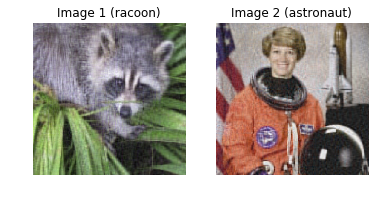

In [72]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(to_image(rec1))
ax.set_axis_off()
plt.title('Image 1 (racoon)')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(to_image(rec2))
ax.set_axis_off()
plt.title('Image 2 (astronaut)')
fig.show()

Much better, right?

You can now try to experiment for yourself with these images and others!